# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID (index) for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : contains ID and output for each data

In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# !pip install skfeature-chappers
# !pip install mlxtend
# !pip --version

Show the installed packages with their versions

In [3]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  2020.02                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  
appdirs                   1.4.3                    pypi_0    pypi
argh                      0.26.2                   py37_0  
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0              py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.3.0                     py_0  
autopep8                  1.4.4                      py_0  
babel                     2.8.

mpmath                    1.1.0                    py37_0  
msgpack-python            0.6.1            py37h74a9793_1  
msys2-conda-epoch         20160418                      1  
multipledispatch          0.6.0                    py37_0  
murmurhash                1.0.2                    pypi_0    pypi
navigator-updater         0.2.1                    py37_0  
nbconvert                 5.6.1                    py37_0  
nbformat                  5.0.4                      py_0  
networkx                  2.4                        py_0  
nltk                      3.4.5                    py37_0  
nose                      1.3.7                    py37_2  
notebook                  6.0.3                    py37_0  
numba                     0.48.0           py37h47e9c7a_0  
numexpr                   2.7.1            py37h25d0782_0  
numpy                     1.18.1           py37h93ca92e_0  
numpy-base                1.18.1           py37hc3f5095_1  
numpydoc                  0.9.2   

In [4]:
Final_Samples_path = 'Final_Samples_4yrs.json'
Final_Samples = json.load(open(Final_Samples_path, 'r')) 
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
# normalize feature matrix
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
# PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
num_features=PRS_orig_feature_matrix.shape[1]
print(num_features)


wcwidth                   0.1.8                      py_0  
webencodings              0.5.1                    py37_1  
werkzeug                  1.0.0                      py_0  
wheel                     0.34.2                   py37_0  
widgetsnbextension        3.5.1                    py37_0  
win_inet_pton             1.1.0                    py37_0  
win_unicode_console       0.5                      py37_0  
wincertstore              0.2                      py37_0  
winpty                    0.4.3                         4  
wrapt                     1.11.2           py37he774522_0  
xlrd                      1.2.0                    py37_0  
xlsxwriter                1.2.7                      py_0  
xlwings                   0.17.1                   py37_0  
xlwt                      1.3.0                    py37_0  
xmltodict                 0.12.0                     py_0  
xz                        5.2.4                h2fa13f4_4  
yaml                      0.1.7        

In [5]:
covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",covar_df.shape)
print( covar_df[['AGE', 'PTGENDER']].shape, covar_df[['AGE', 'PTGENDER']].dropna().shape ) 
# PC - Principal Component

# trying to normalize AGE with having max age of 100
covar_df['AGE'] = covar_df['AGE'] / 100.0
print( covar_df.head() )

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER    AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  0.691  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  0.707  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  0.655  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  0.714  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [6]:
num_features = 39
hidden = 4
hidden_dimension = 32

In [7]:
# take the first num_features column from PRS_feature_matrix
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 39)


Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [8]:
# positive samples - output true
# negative samples - output false
len_positive_samples = 0
len_negative_samples = 0
for x in Final_Samples:
    if x[1] == 1 :
        len_positive_samples += 1
    else :
        len_negative_samples += 1
        
print(len(Final_Samples))
print(len_positive_samples)
print(len_negative_samples)

1158
654
504


# Combining covar data with PRS Feature Matrix

In [9]:
# cnt = number of missing IDs for which covar data doesn't exist
cnt = 0
print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# adding ( total columns - 2 ) of covar_df , excluding FID, IID
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    # taking from the PCs, skipping the first two columns of IID, FID
    covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
    # shape[0] = 1 means a row is found in covar for the following sample ID
    # if not, that means no covar data exists for the sample in usable_samples_ADNI
    if covar.shape[0] != 1:
#         print(covar.shape)
#         print(sample)
        cnt += 1
        continue
    # Adding the covar values to the feature matrix
    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


print("Count of missing samples for covar data : ", cnt)
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

Before adding covar_df columns, shape :  (1816, 39)
Before adding covar_df columns, shape :  (1816, 51)
Count of missing samples for covar data :  234


# Create directory for saving shap figures

In [10]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [11]:
age_zero = 0
age_zero_idx = []
for i in range( len(FEATURE_MATRIX) ):
    if FEATURE_MATRIX[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
        
print(age_zero)

234


# Indices of features to consider

In [12]:


# feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# naeem modified
print(FEATURE_MATRIX.shape[1])
last_idx = FEATURE_MATRIX.shape[1] - 1
feature_indices_to_consider = list(range(num_features))  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# remove_indices = [1, 2, 3]
# for i in remove_indices:
#     feature_indices_to_consider.remove(i)

# feature_indices_to_consider = list(range(23, 36))

# feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# feature_indices_to_consider = [9, 10, 28, 34, 46]

print(feature_indices_to_consider)
# feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# feature_indices_to_consider = [2, 26, 32, 45]


51
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 49, 50]


# Functions & Classes

In [13]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

In [14]:
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [15]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (fc1): Linear(in_features=41, out_features=32, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [16]:
class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [17]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [19]:
# random samples : sample test dataset taking equal number of positive & negative outputs
#                 args : 
#                         total_folds : fold number for splitting
#                         random_seed : seed value for randomization
#                 return :
#                         N_splits : test dataset splitted according to fold numbers
                        
def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open(Final_Samples_path, 'r')) 
    positive_samples = Final_Samples[:len_positive_samples]
    negative_samples = Final_Samples[len_positive_samples:]
    min_len = min( len(positive_samples), len(negative_samples))
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    print("min length : ", min_len)
    Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
    random.shuffle(Final_Samples)
    print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
    Final_Samples = np.array(Final_Samples)

#   -----------------------------------------------------------------------
#     positive_samples = Final_Samples[:654]
#     negative_samples = Final_Samples[654:]
#     if random_seed is not None: 
#         random.seed(random_seed * 2)
#     random.shuffle(positive_samples)
#     random.shuffle(negative_samples)
#     Final_Samples = positive_samples[:500] + negative_samples[:500]
#     if random_seed is not None: 
#         random.seed(random_seed)
#     random.shuffle(Final_Samples)
#     Final_Samples = np.array(Final_Samples)
# --------------------------------------------------------------------------
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

# generate_datasets : get train, validation & test datasets
#                 args : 
#                         N_splits : data splitted according to folds; output of random samples
#                         fold_num : fold_num for test dataset
#                         random_seed : seed value for randomization
#                 return :
#                         train_set, test_set, val_set : datasets
def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    # take all as training dataset, leaves nothing for validation - multiply shpae by 1
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    # normalize dataset
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
#     print(len(train_set))
#     print(len(val_set))
#     print(len(test_set))
    return train_set, val_set, test_set



# generate_loader : get train, validation & test as torch dataset
#                 args : 
#                         train_set, test_set, val_set : datasets
#                 returns :
#                         train, val & test torch datasets
def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

# train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
# val_set.feature_matrix.shape

In [20]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    


**epoch function for LOOCV**

Without precision, recall, ROC, AUC 

In [21]:
def loocv_epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
#     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
#     auroc = roc_auc_score(true, pred)
#     p, r, thresholds = precision_recall_curve(true, pred)
#     auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    

# usable_samples_ADNI from a PRSice output

In [22]:
import json
import pandas as pd
GWAS_ID = 'ieu-b-25'
usable_samples_ADNI = pd.read_csv(f'./PRSice_output/{GWAS_ID}/{GWAS_ID}.best', ' ')['IID'].to_numpy().tolist()
usable_samples_ADNI = {'_'.join(sample.split('_')[1:]):idx for idx,sample in enumerate(usable_samples_ADNI)}
# usable_samples_ADNI = {sample:idx for idx,sample in enumerate(usable_samples_ADNI)}
print(len( usable_samples_ADNI ))

1816


In [23]:
# usable_indices : take indices from usable_samples_ADNI which are in Final_Samples
# usable_features : take the part of feature matrix with usable_indices( rows )
#                   and feature_indices_to_consider ( columns )

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)


1158
1158
Shape of usable features :  (1158, 41)


# Removing age values with 0

In [24]:
# removing age with value 0
#--------------------------------------------------------------------------------
age_zero = 0
age_zero_idx = []
for i in range(len(usable_features)):
    if usable_features[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
print(len(age_zero_idx))
print(usable_features.shape, len( Final_Samples ) )
usable_features = np.delete(usable_features, age_zero_idx, axis = 0)
Final_Samples = np.delete(Final_Samples, age_zero_idx, axis = 0)
print(usable_features.shape, len( Final_Samples ) )
print(Final_Samples[0])
#--------------------------------------------------------------------------------

205
(1158, 41) 1158
(953, 41) 953
['130_S_4990' '1']


# usable_labels : output

In [25]:
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))

Length of usable labels :  953


# Read all traits from json file 

In [26]:
all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(traits)

['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzhei

# Get traits corresponding to features

In [27]:
print(PRS_orig_feature_matrix.shape[1])
# print(feature_indices_to_consider)

print(len(traits))
print(feature_indices_to_consider)

# check if age and gender is included
# if they are included, their index will be larger than the original feature matrix
if any(y >PRS_orig_feature_matrix.shape[1] for y in feature_indices_to_consider):
    features = feature_indices_to_consider.copy()
    age_include = False
    gender_include = False
    print(features[-2])
    if(features[-2] == PRS_orig_feature_matrix.shape[1] + 10):
        print("gender_include")
        features.pop(-2)
        gender_include = True
    print(features[-1])
    if(features[-1] == PRS_orig_feature_matrix.shape[1] + 11):
        print("age include")
        features.pop(-1)
        age_include = True
    
    print(features)
    traits = [ traits[i] for i in features]
    if gender_include == True:
        traits.append("gender")
    if age_include == True:
        traits.append("age")
    
#     traits.append("output prediction")
#     traits.append("age")
#     traits.append("gender")
else:
    # not included - age, gender
    traits = [ traits[i] for i in feature_indices_to_consider]
print(traits)


39
39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 49, 50]
49
gender_include
50
age include
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'He

# Panda dataframe conversion

In [28]:
total_features = np.c_[ usable_features, usable_labels ]
# print(total_features.shape)
# print(num_features)
# column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
column_list = feature_indices_to_consider + [num_features]
# print( column_list )

df = pd.DataFrame(total_features, columns = column_list )

# turn column names to strings
# df.columns = df.columns.astype(str)

# assign traits as column names
column_names = traits.copy()
column_names.append('output')
df.columns = column_names
# print( df.columns )

# dropping last / output column in df
df_X = df.iloc[: , :-1]
# taking the output column of df
df_Y = df.iloc[: , -1]

print( df.head() )
# print( df_X.head() )
# print( df_Y.head() )



   Non-cancer illness code, self-reported: type 2 diabetes  \
0                                          -0.462662         
1                                           0.912211         
2                                           0.399906         
3                                          -0.128951         
4                                           0.869971         

   Ever had known person concerned about, or recommend reduction of, alcohol consumption: No  \
0                                          -0.648048                                           
1                                           0.056427                                           
2                                          -0.482298                                           
3                                           0.342396                                           
4                                           7.341939                                           

   Ever had known person concerned about, or recom

# Get equal amount of positive & negative data

In [29]:
print( df['output'].value_counts() )

ones = df[df['output'] == 1]
zeros = df[df['output'] == 0]
min_len = min( len(ones), len(zeros) ) 

ones = ones.iloc[:min_len, :]
zeros = zeros.iloc[:min_len, :]

df = ones.append(zeros, ignore_index=True)
print(df.shape)

1.0    576
0.0    377
Name: output, dtype: int64
(754, 42)


# Shuffling dataframe

**Dropping alcohol recommended columns**

In [30]:
# # keep the index same
# shuffled = df.sample(frac=1)
# print( shuffled.head() )

# reset the index
shuffled = df.sample(frac=1).reset_index()
# print(shuffled.columns)
shuffled = shuffled.drop( ['index'], axis = 1 )


#  dropping alcohol recommended columns
shuffled = shuffled.drop(['Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year'], axis = 1)

print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
# taking the output column of df
shuffled_Y = shuffled.iloc[: , -1]

   Non-cancer illness code, self-reported: type 2 diabetes  Total cholesterol  \
0                                           0.682379                -2.552023   
1                                          -0.539520                 0.340756   
2                                          -2.253678                 0.640069   
3                                          -0.855157                 1.083550   
4                                           0.932660                 0.649297   

   HDL cholesterol  LDL cholesterol  triglycerides  Cigarettes per Day  \
0         0.285940        -2.127463      -1.468258           -0.534079   
1         0.355819         0.224532       0.299265           -0.566655   
2         1.147380        -0.210157      -0.903759           -0.436664   
3         0.254300         0.990490       0.329768            0.272117   
4         0.011761         0.147626      -0.242728            0.727740   

   systolic blood pressure  diastolic blood pressure  \
0           

In [31]:
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

print(usable_features.shape)

Usable Features :  tensor([[-0.4627, -0.6480, -0.0794,  0.1311,  1.1495,  0.7602, -0.2291, -0.0194,
         -0.1059,  0.3283,  0.2490,  0.1892,  0.0489, -0.0173, -0.6989,  0.1007,
         -0.4208,  1.3157,  0.0143, -0.5942,  1.8406, -0.5280,  0.9571, -0.2773,
          0.1623, -0.4717, -0.2013, -0.7583, -0.8045,  1.7036, -0.1098, -1.5142,
         -0.3337,  1.4652, -0.4024,  1.0879,  0.3157,  0.0433, -0.1037,  1.0000,
          0.7510],
        [ 0.9122,  0.0564,  0.8030,  0.6610,  1.5529,  0.2748,  0.7089,  1.1561,
          0.2082,  0.0685,  0.5163,  0.7540,  0.2753,  0.3280,  0.8489, -0.9714,
         -1.1119, -0.1211,  1.1405,  0.1947,  0.8091,  0.9293, -0.3776,  1.4377,
         -1.1980, -0.8536,  1.0828, -1.0338, -0.9021,  1.4836,  0.0362,  0.5772,
          0.7052, -0.2747,  0.9789, -0.4097, -0.5603,  0.7936,  1.1413,  1.0000,
          0.7090]])
torch.Size([953, 41])


# Feature Analysis

Non-cancer illness code, self-reported: type 2 diabetes


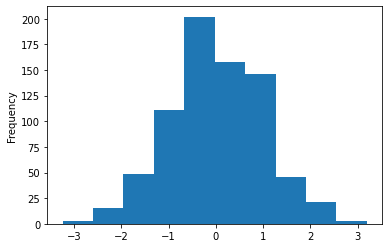

Total cholesterol


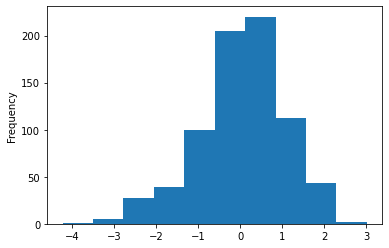

HDL cholesterol


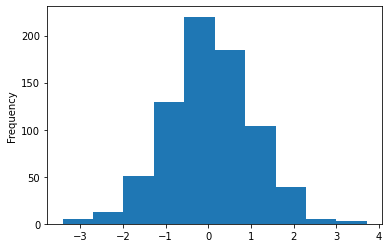

LDL cholesterol


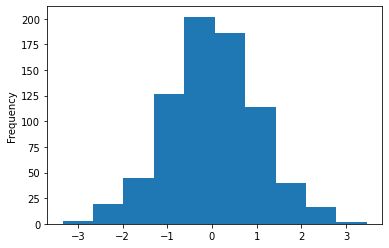

triglycerides


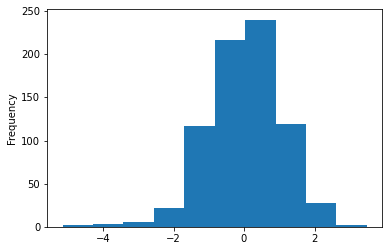

Cigarettes per Day


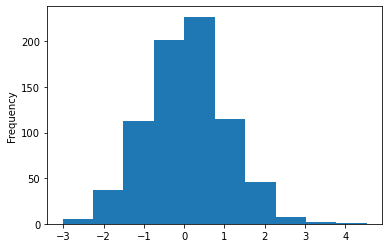

systolic blood pressure


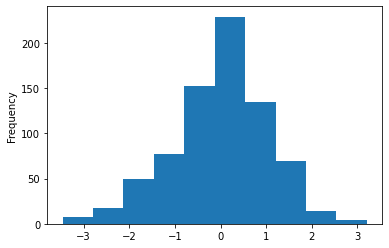

diastolic blood pressure


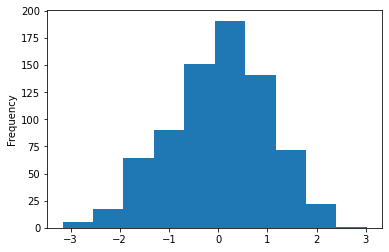

Hearing difficulty/problems: Yes


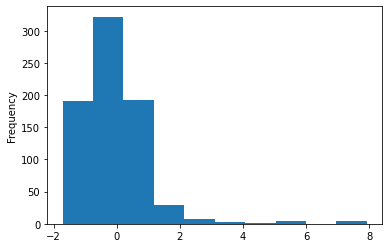

Non-cancer illness code, self-reported: depression


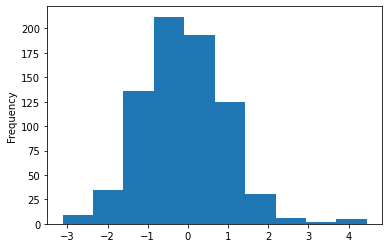

Non-oily fish intake


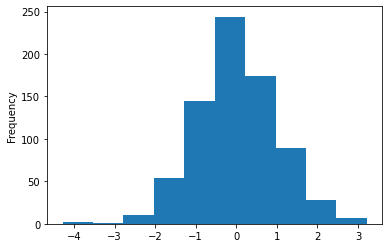

Hearing difficulty/problems with background noise


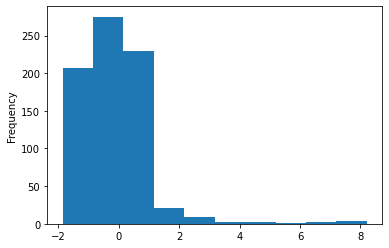

Body mass index (BMI)


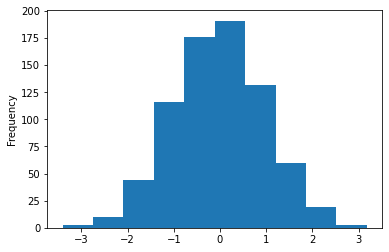

Oily fish intake


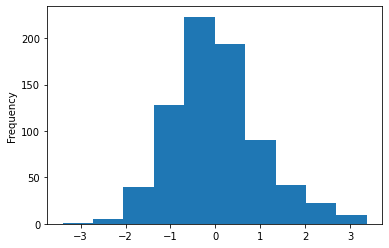

Sleeplessness / insomnia


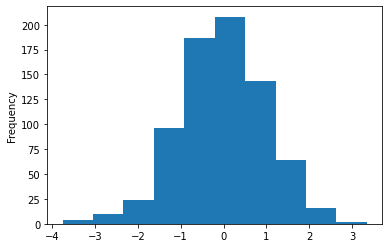

Sleep duration


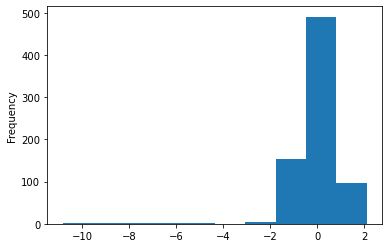

Age completed full time education


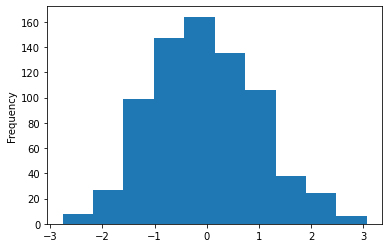

Processed meat intake


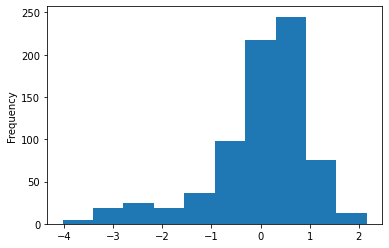

Types of physical activity in last 4 weeks: Strenuous sports


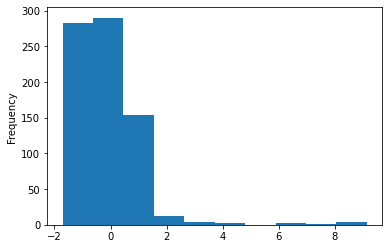

Other meat intake


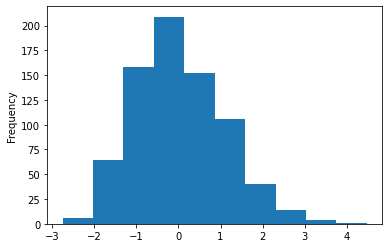

Loneliness, isolation


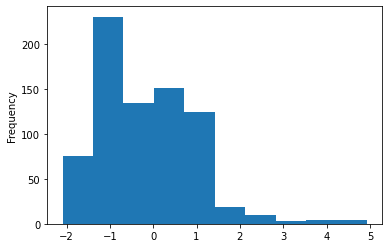

Illnesses of father: Alzheimer's disease/dementia


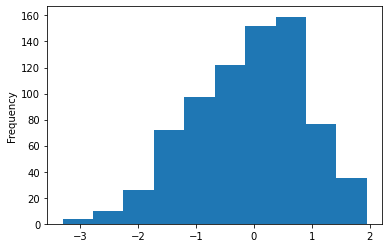

Illnesses of mother: Alzheimer's disease/dementia


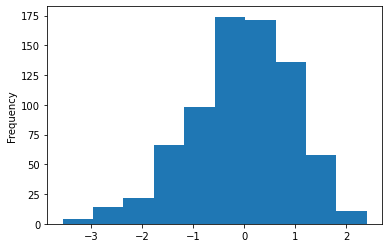

Mood swings


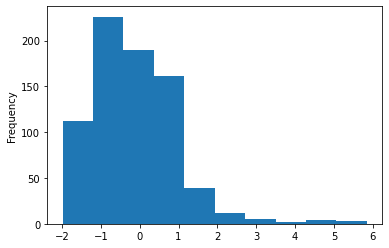

Non-cancer illness code, self-reported: anxiety/panic attacks


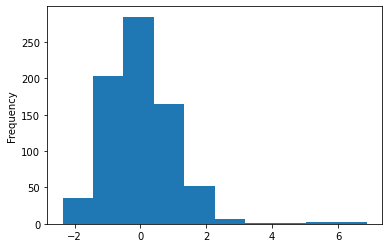

Non-cancer illness code, self-reported: stroke


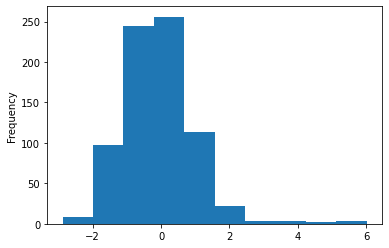

Non-cancer illness code, self-reported: head injury


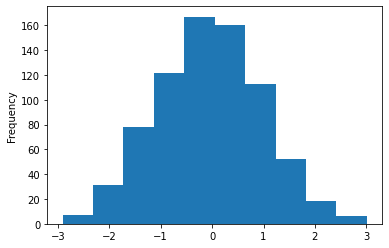

Alcohol intake frequency


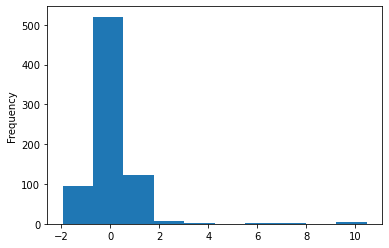

Diagnoses - secondary ICD10: E66.9 Obesity, unspecified


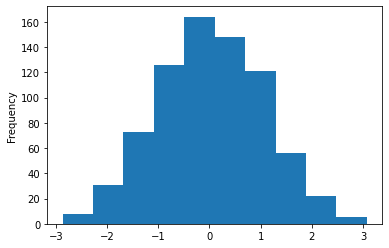

Non-cancer illness code, self-reported: hypothyroidism/myxoedema


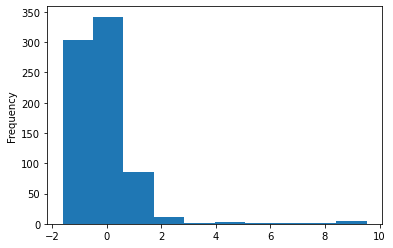

Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis


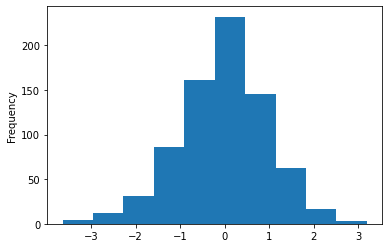

Non-cancer illness code, self-reported: hypertension


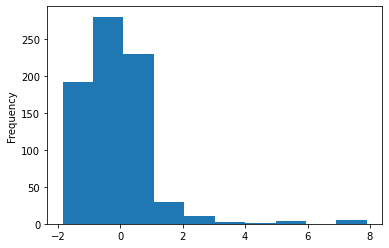

Particulate matter air pollution 2.5-10um; 2010


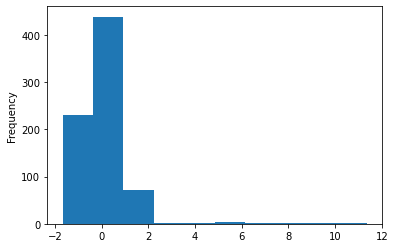

Nitrogen oxides air pollution; 2010


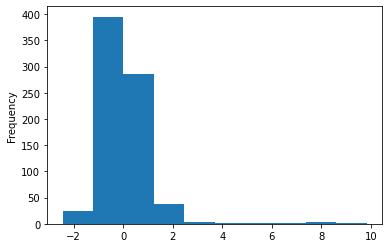

Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)


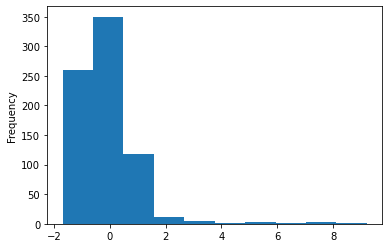

Diagnoses - secondary ICD10: I10 Essential (primary) hypertension


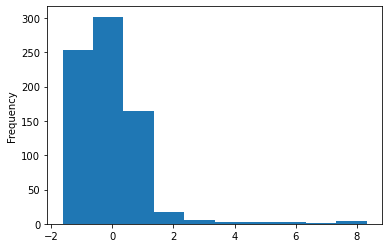

gender


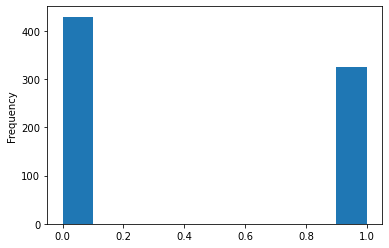

age


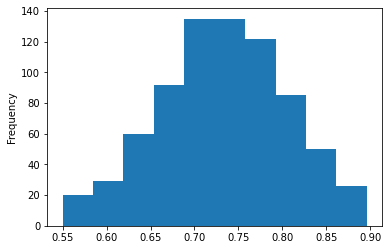

output


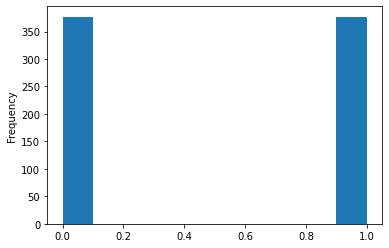

In [32]:
# print(df.head())
column_list = shuffled.columns
for i in column_list:
    print(i)
    shuffled[i].plot(kind="hist")
    plt.show()

# Feature Selection
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [33]:
selected_features = []

# Filter methods
Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. These methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods.

**Information Gain**

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

['Hearing difficulty/problems: Yes', 'Hearing difficulty/problems with background noise', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', 'Mood swings', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension']


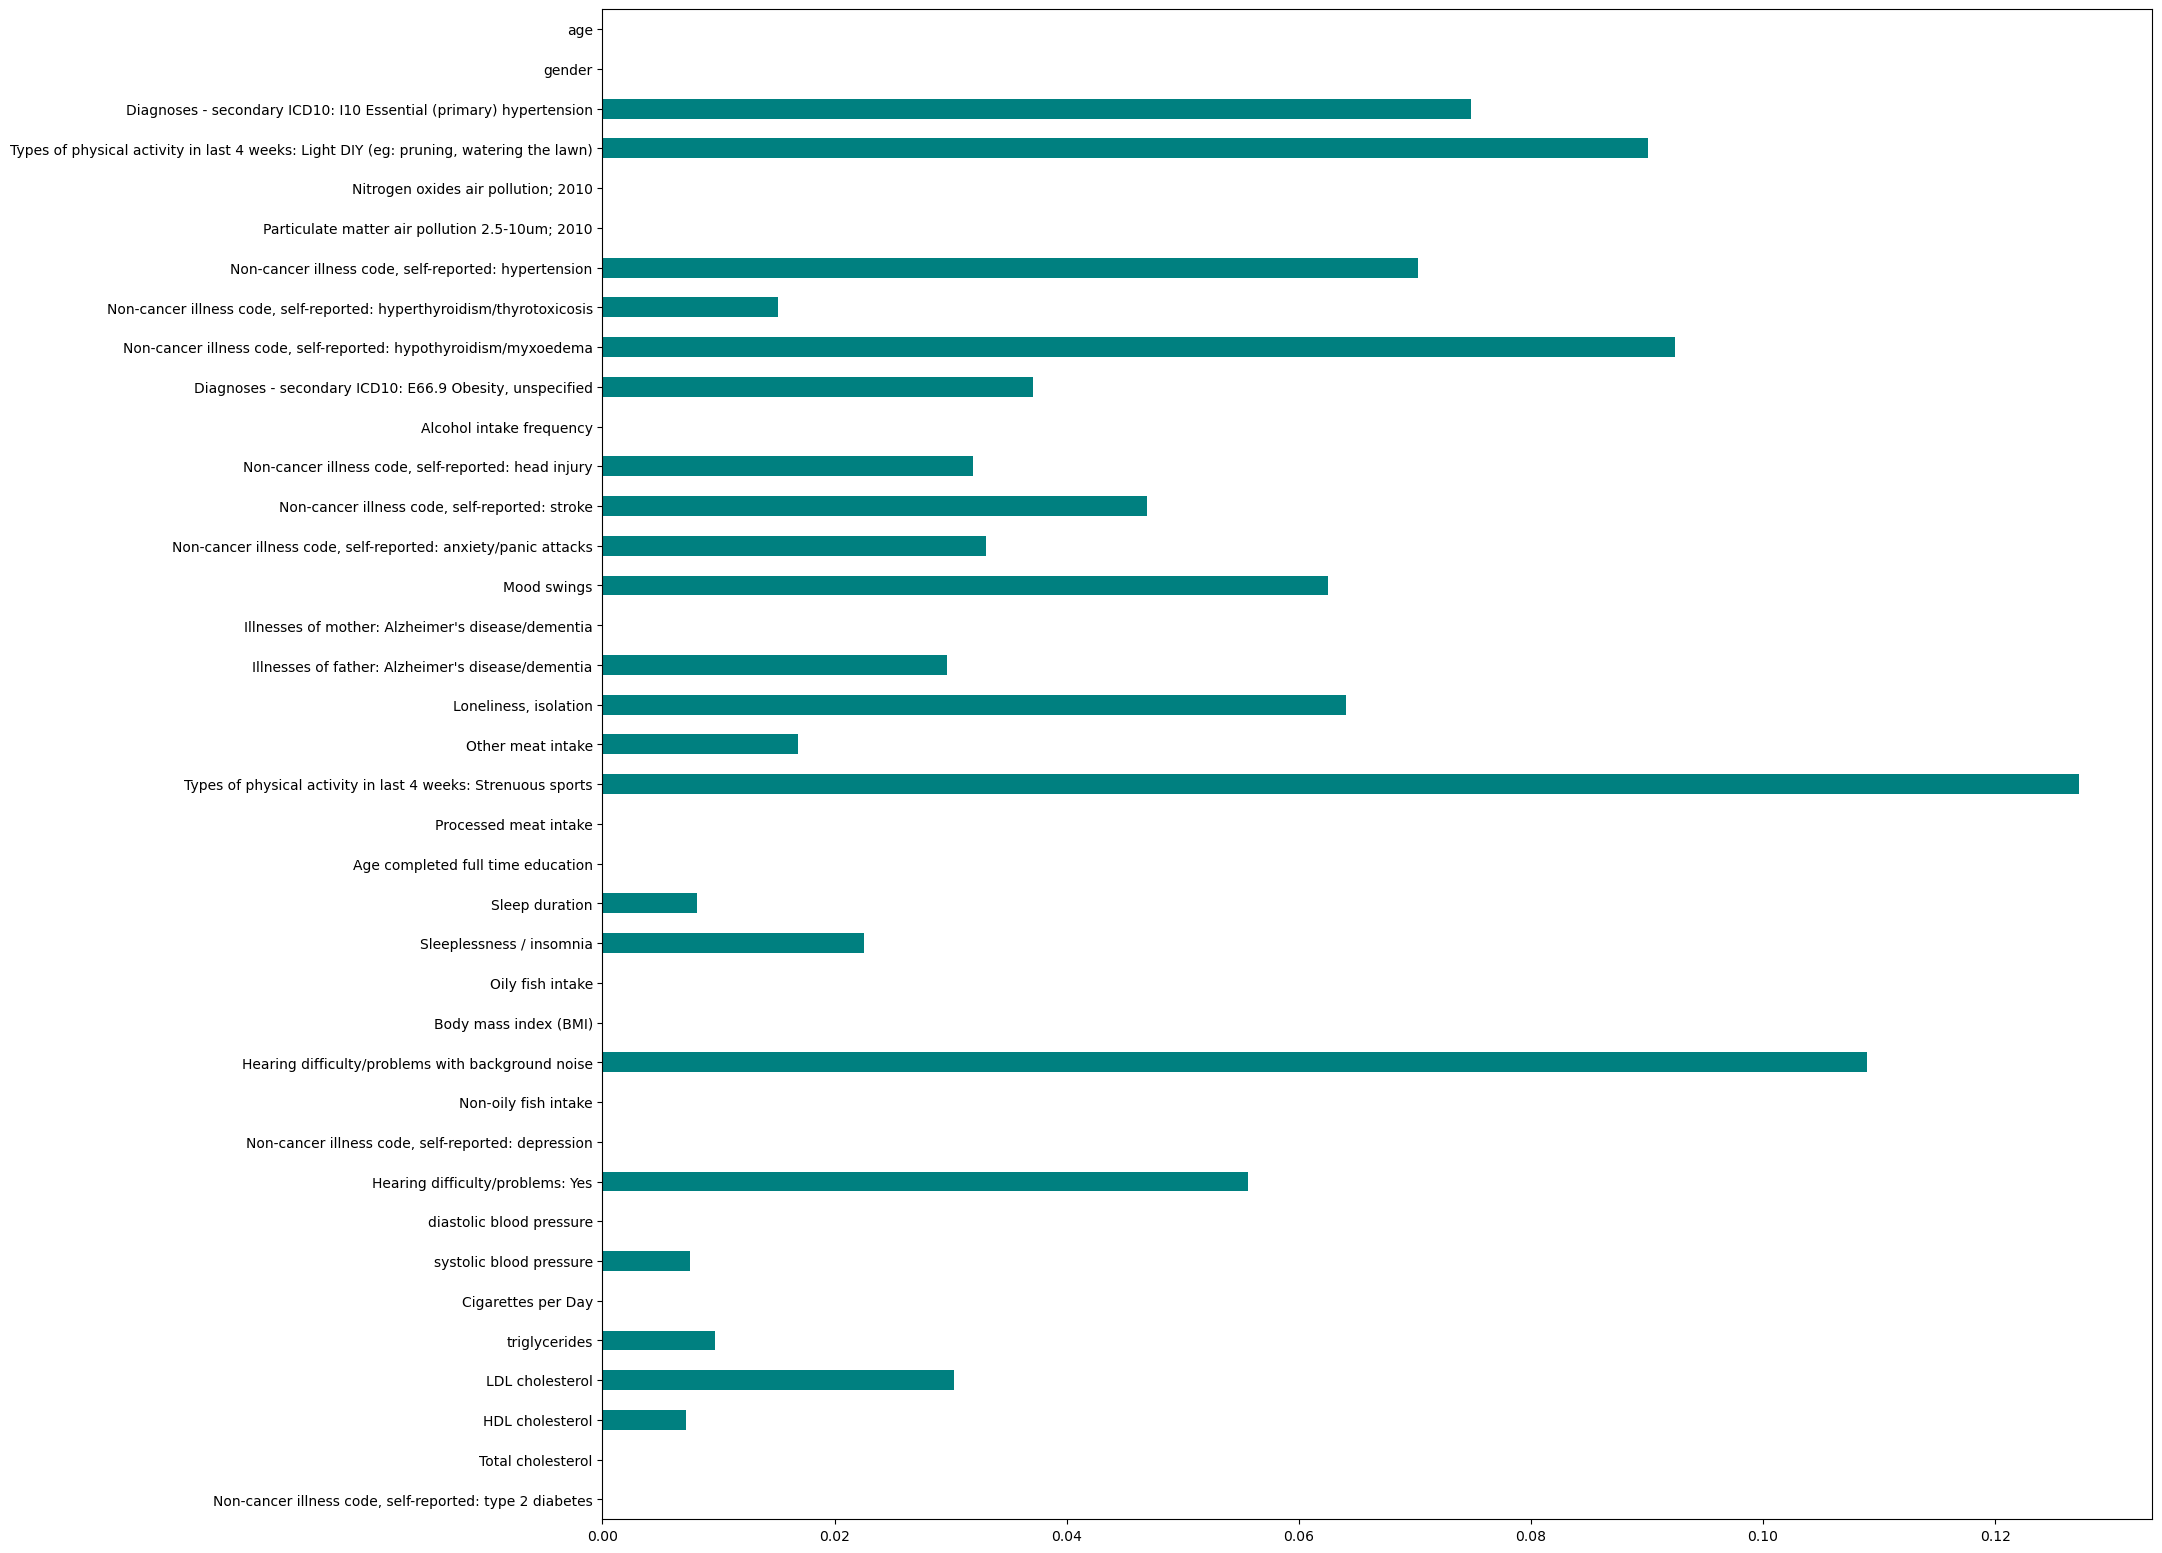

In [34]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=100)

importances = mutual_info_classif(shuffled_X, shuffled_Y)
feat_importances = pd.Series(importances, shuffled.columns[ 0:len(shuffled.columns) - 1 ] )
important_features = []
count = 0
for elem in feat_importances:
    if elem > 0.05:
        important_features.append(shuffled.columns[count])
    count += 1
print(important_features)

selected_features += important_features
# print(selected_features)

feat_importances.plot( kind = 'barh', color = 'teal' )
plt.show()

**Correlation Coefficient**


<AxesSubplot:>

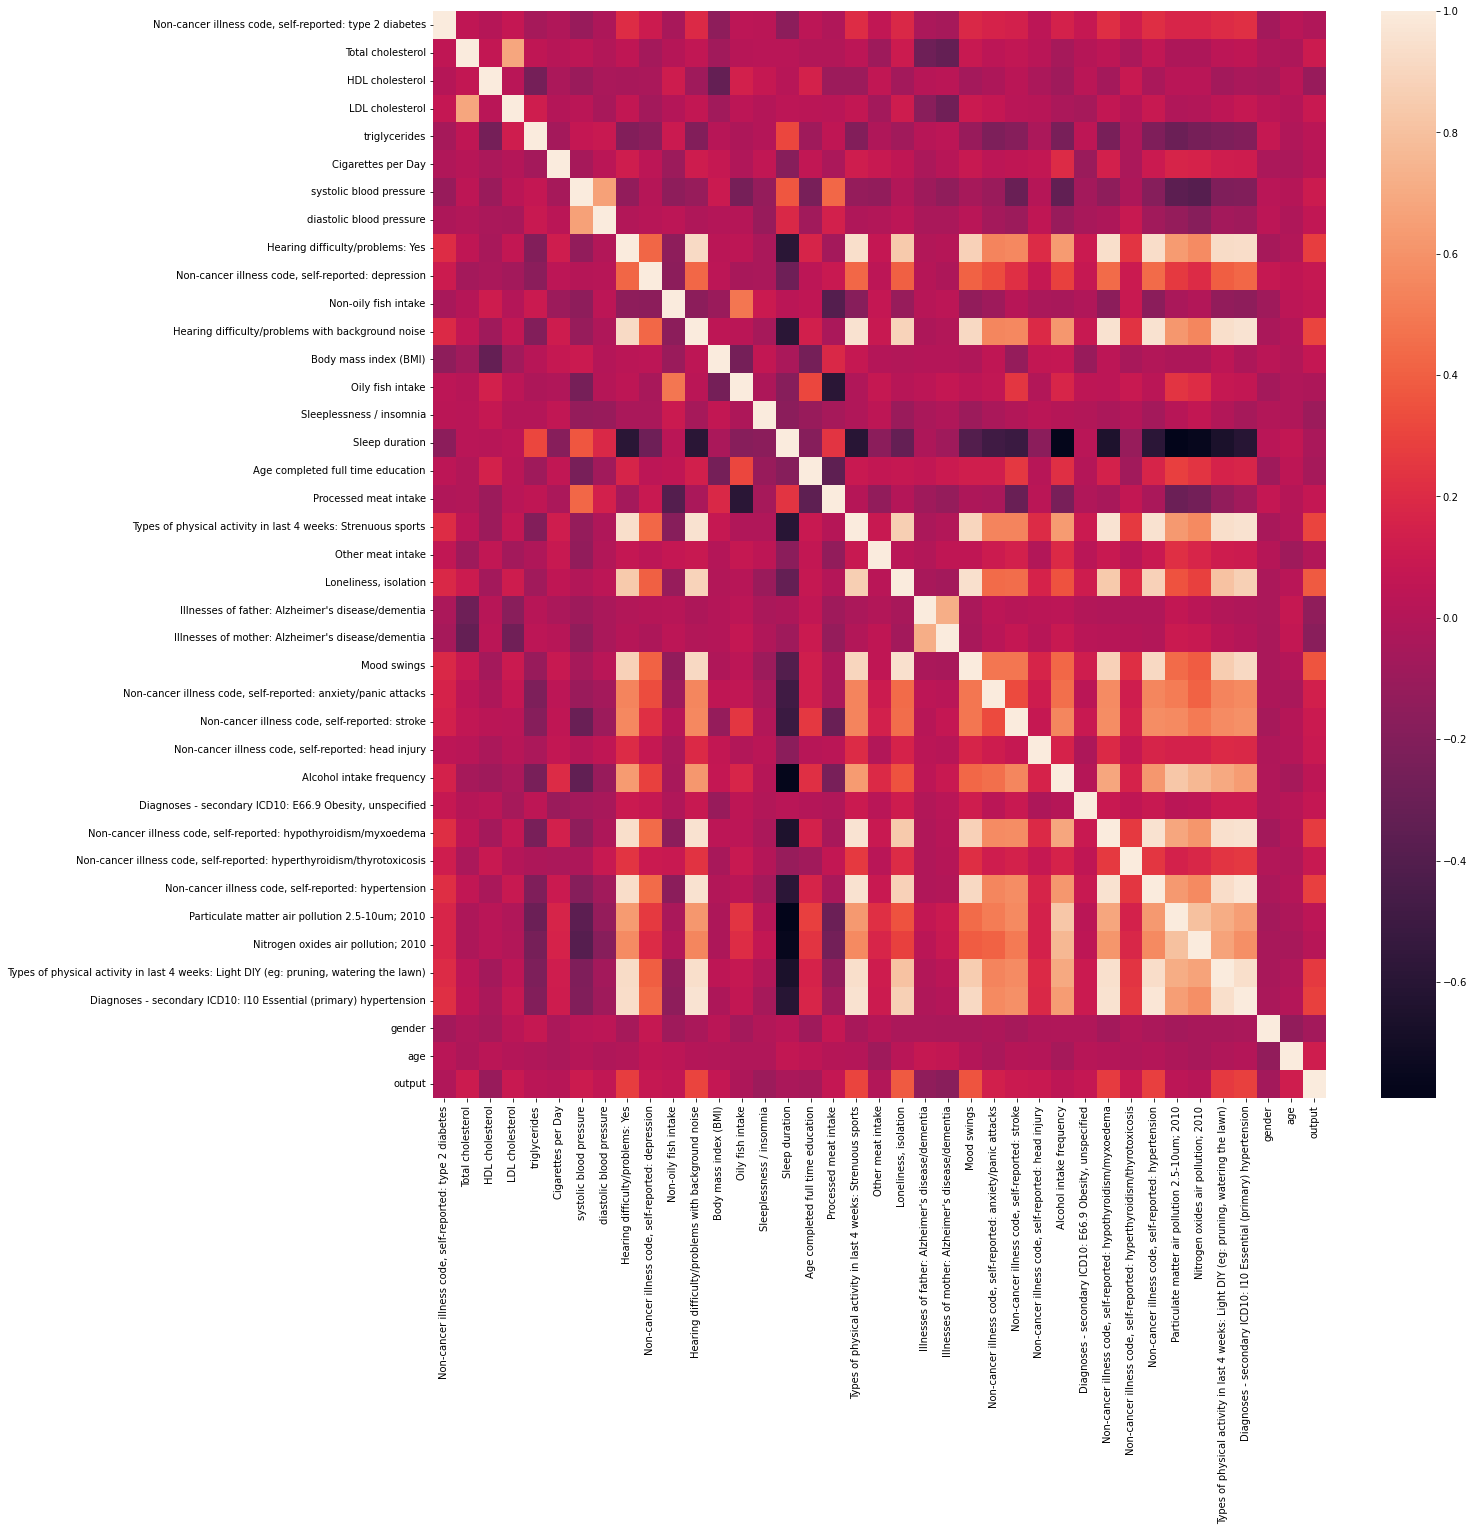

In [35]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
corr = shuffled.corr()
sns.heatmap( corr )

In [36]:
print(corr.iloc[0][0])
features_selected = []
column_len = len( shuffled.columns )
output_idx = column_len - 1

for i in range( column_len ): 
    if (corr.iloc[i][output_idx] > 0.1 ) and i != output_idx :
        features_selected.append(shuffled.columns[i])
print(features_selected)

selected_features += features_selected

1.0
['Total cholesterol', 'systolic blood pressure', 'Hearing difficulty/problems: Yes', 'Hearing difficulty/problems with background noise', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', 'Mood swings', 'Non-cancer illness code, self-reported: anxiety/panic attacks', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 'age']


**Variance Threshold**

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.

In [37]:
from sklearn.feature_selection import VarianceThreshold

# remove features with variance less than 0.1
v_threshold = VarianceThreshold( threshold = 0.1 )
v_threshold.fit(shuffled_X)
print( v_threshold.get_support() )
rejected_col = [x for x, y in zip(shuffled_X.columns, v_threshold.get_support() ) if y == False]
print(rejected_col)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False]
['age']


Makes sense as most of the age is very high for AD patients. No need to reject the "age" column

**Mean Absolute Difference (MAD)**

The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant.’ This means that higher the MAD, higher the discriminatory power.

<BarContainer object of 38 artists>

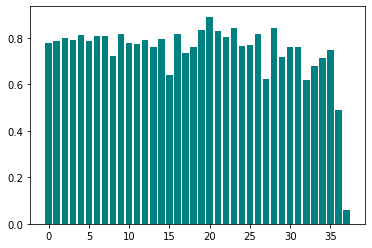

In [38]:
mean_abs_diff = np.sum( np.abs( shuffled_X - np.mean(shuffled_X, axis = 0 ) ), axis = 0 ) / shuffled_X.shape[0]

plt.bar( np.arange( shuffled_X.shape[1] ), mean_abs_diff, color = 'teal' )

# Wrapper Methods

Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

**Forward Feature Selection**

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved.

In [39]:
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(shuffled_X, shuffled_Y)

ffs = SequentialFeatureSelector( rfc, k_features = 'best', forward = True, n_jobs = -1 )
ffs.fit(shuffled_X, shuffled_Y)
features = list( ffs.k_feature_names_ )
print(features)
print( len( features ) )

selected_features += features
# print(selected_features)

['triglycerides', 'systolic blood pressure', 'Types of physical activity in last 4 weeks: Strenuous sports', "Illnesses of father: Alzheimer's disease/dementia", 'Alcohol intake frequency', 'Non-cancer illness code, self-reported: hypertension', 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 'age']
8


**Backward Feature Elimination**

This method works exactly opposite to the Forward Feature Selection method. Here, we start with all the features available and build a model. Next, we remove the variable from the model which gives the best evaluation measure value. This process is continued until the preset criterion is achieved.

In [40]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

lr = LogisticRegression( class_weight = 'balanced', solver = 'lbfgs', random_state = 42, n_jobs = -1, max_iter = 500 )
lr.fit(shuffled_X, shuffled_Y)

bfs = SequentialFeatureSelector( lr, k_features = 'best', forward = False, n_jobs = -1 )
bfs.fit(shuffled_X, shuffled_Y)
features = list( bfs.k_feature_names_ )
print(features)
print( len( features ) )

selected_features += features
# print(selected_features)

['Cigarettes per Day', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings', 'Non-cancer illness code, self-reported: head injury', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified', 'Nitrogen oxides air pollution; 2010', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'gender', 'age']
20


**Exhaustive Feature Selection**

This is the most robust feature selection method covered so far. This is a brute-force evaluation of each feature subset. This means that it tries every possible combination of the variables and returns the best performing subset.

In [41]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector

# from sklearn.ensemble import RandomForestClassifier

# efs = ExhaustiveFeatureSelector( RandomForestClassifier(), min_features = 8, max_features = 10, scoring = 'roc_auc', cv = 2)
# efs.fit(shuffled_X, shuffled_Y)

# selected_features = shuffled_X.columns[list(efs.best_idx_)]
# print(selected_features)

# print(efs.best_score_)

**Recursive Feature Elimination**

‘Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.’

In [42]:
from sklearn.feature_selection import RFE
# here lr denotes the logistic regression model trained on backward elimination
rfe = RFE(lr, n_features_to_select = 10)
rfe.fit(shuffled_X, shuffled_Y)
selected_col = [ x for x, y in zip(shuffled_X.columns, rfe.support_ )  if y == True ]
print(selected_col)
print( len (selected_col ) )
print(rfe.ranking_)

selected_features += selected_col 
# print(selected_features)

['Non-oily fish intake', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'age']
10
[ 5 20  4 27 28 15  8 11 24  7  1 26  9 19  6 16 25  1  1 22  1 13  1  1
 23 29 14 17 10  1 21  1 18 12  1  3  2  1]


# Embedded Methods

These methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

**LASSO Regularization (L1)**

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e. to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

logistic = LogisticRegression( C = 1, penalty = "l1", solver = 'liblinear', random_state = 7 ).fit(shuffled_X, shuffled_Y )

model = SelectFromModel(logistic, prefit = True )

X_new = model.transform(shuffled_X)

selected_feat = shuffled_X.columns[(model.get_support())]
print(selected_feat)
print( len( selected_feat ) )
# selected_columns = shuffled_X.columns[X_new.var() != 0 ]
# print(selected_columns)
# print( len(selected_columns[0] ) )
# print(type(selected_feat))
# print( selected_feat.tolist() )
selected_features += selected_feat.tolist()

# print(selected_features)

Index(['Non-cancer illness code, self-reported: type 2 diabetes',
       'Total cholesterol', 'HDL cholesterol', 'triglycerides',
       'Cigarettes per Day', 'systolic blood pressure',
       'diastolic blood pressure',
       'Non-cancer illness code, self-reported: depression',
       'Non-oily fish intake', 'Body mass index (BMI)', 'Oily fish intake',
       'Sleeplessness / insomnia', 'Sleep duration',
       'Age completed full time education', 'Processed meat intake',
       'Types of physical activity in last 4 weeks: Strenuous sports',
       'Other meat intake', 'Loneliness, isolation',
       'Illnesses of father: Alzheimer's disease/dementia',
       'Illnesses of mother: Alzheimer's disease/dementia', 'Mood swings',
       'Non-cancer illness code, self-reported: anxiety/panic attacks',
       'Non-cancer illness code, self-reported: head injury',
       'Alcohol intake frequency',
       'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified',
       'Non-cancer illness

**Random Forest Importance**

Random Forests is a kind of a Bagging Algorithm that aggregates a specified number of decision trees. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features.

<AxesSubplot:>

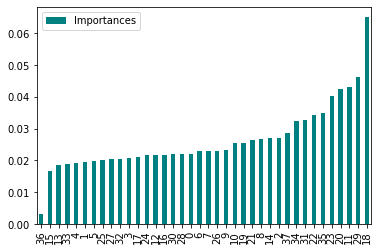

In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( n_estimators = 340 )

model.fit(shuffled_X, shuffled_Y)

importances = model.feature_importances_

final_df = pd.DataFrame({"Features" : pd.DataFrame(shuffled_X).columns, "Importances" : importances } )
final_df.set_index('Importances')

final_df = final_df.sort_values('Importances')
final_df.plot.bar(color = 'teal')

In [45]:
# print(type( final_df ) )
# print(final_df.columns)
# print(final_df['Features'].iloc[-10:])
important_cols = []
important_cols = final_df['Features'].iloc[-10:].values.tolist()
print(important_cols)

selected_features += important_cols

['age', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Non-cancer illness code, self-reported: hypertension', "Illnesses of mother: Alzheimer's disease/dementia", 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 'Mood swings', 'Loneliness, isolation', 'Hearing difficulty/problems with background noise', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Types of physical activity in last 4 weeks: Strenuous sports']


# Select features based on all methods

https://www.digitalocean.com/community/tutorials/python-counter-python-collections-counter

In [46]:
from collections import Counter
# print(selected_features)
c = Counter( selected_features )
# print( c )
# print( c.most_common(20) )
most_common = c.most_common(15)
print( most_common )
selected_col = list( list(zip(*most_common))[0] )
print(selected_col)

[('Types of physical activity in last 4 weeks: Strenuous sports', 7), ('Loneliness, isolation', 6), ('Mood swings', 6), ('Non-cancer illness code, self-reported: hypertension', 6), ('Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 6), ('age', 6), ('Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 5), ('Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 5), ("Illnesses of mother: Alzheimer's disease/dementia", 4), ('Hearing difficulty/problems: Yes', 3), ('Hearing difficulty/problems with background noise', 3), ('systolic blood pressure', 3), ('Non-oily fish intake', 3), ('Processed meat intake', 3), ('Total cholesterol', 2)]
['Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', 'Mood swings', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'age', 'Non-cancer illness code, self-re

# Drop extra features from Shuffled Dataframe

In [47]:
selected_col += ['output']
shuffled = shuffled[selected_col]

print( shuffled.shape )
print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]



(754, 16)
   Types of physical activity in last 4 weeks: Strenuous sports  \
0                                          -0.362357              
1                                          -0.294327              
2                                           0.330409              
3                                          -1.409661              
4                                          -0.437772              

   Loneliness, isolation  Mood swings  \
0              -0.595207    -0.603468   
1              -0.412728    -0.136834   
2               0.510350     0.199374   
3              -0.945129    -0.835446   
4              -0.936552    -0.885636   

   Non-cancer illness code, self-reported: hypertension  \
0                                          -0.522035      
1                                          -0.794757      
2                                           0.191820      
3                                          -0.621976      
4                                          -0

# LOOCV

**Random Forest Classifier with LOOCV**

In [48]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# print(shuffled_X.shape)
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(shuffled_X):
    # split data
#     print(train_ix, test_ix)
    X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
    y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
    # fit model
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
#     print(y_test[0], yhat[0])
#  print(len( y_test ), len( yhat ) )
    y_true.append(y_test)
    y_pred.append(yhat)
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.700


**Neural Network Model with LOOCV**

Epoch number is reduced to 250

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# print(shuffled_X.shape)

avg_val_acc = []
accuracies = []
accuracies_val = []
acc_score = []
total_epochs = 250 #250(ideal)


# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(shuffled_X):
    # split data
#     print(train_ix, test_ix)
    X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
    y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
    
    train_dataset = df_dataSet( X_train, y_train )
    valid_dataset = df_dataSet( X_test, y_test )
                
    train_batch_size = train_dataset.__len__()
    val_batch_size = valid_dataset.__len__()
                

                
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

    model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss() 
    best_acc_val = 0.
    model_best = None
                
    for epoch_num in range(total_epochs):
#       print(epoch_num)
        model.train()
#       model.drop_probab=.8
#       print("model trained")
        precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = loocv_epoch(model=model, optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=True, 
                                                                               loader=train_loader)
#                     print("model validated")
        model.eval()
#       model.drop_probab=.0
        precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = loocv_epoch(model=model, 
                                                                                 optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=False, 
                                                                                loader=valid_loader)
#       print("model kahini done")
        if acc_val >= best_acc_val:
            best_acc_val = acc_val
            model_best = model.to(DEVICE)

    model_best.eval()
    precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = loocv_epoch(model=model_best, 
                                                                             optimizer=optimizer, 
                                                                             criterion=criterion, is_training=False, 
                                                                             loader=valid_loader)
    accuracies += [acc_test]
    accuracies_val += [best_acc_val]
    
    if test_ix % 50 == 0:
        print(test_ix, ':', acc_test)
   


   

print( 'Accuracy', np.sum( accuracies ) / len( accuracies ) )

[0] : 0.0
[50] : 1.0
[100] : 1.0
[150] : 0.0
[200] : 1.0
[250] : 1.0


# Model training

In [ ]:
tensor_X = torch.tensor(shuffled_X.values, dtype=torch.float32)

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features_list = [shuffled_X.shape[1]]
# random_integers = [2, 6, 108, 90, 5]
random_integers = [90]#, 92, 0, 87, 73, 82, 54]

folds_list = [10]#[37*2]

avg_val_acc = []

shap_values_list = []
for num_features in num_features_list:
    print(f'NF:{num_features}')
    global_best_acc_val = 0.
    precision_avg = 0
    recall_avg = 0
    auprc_avg = 0
    auroc_avg = 0
    fscore_avg = 0
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            accuracies = []
            accuracies_val = []
            temp_shap_values = np.zeros(shuffled_X.shape)
            
            kf = KFold(n_splits = total_folds, random_state=None)
            acc_score = []

            for train_index , test_index in kf.split(shuffled):
                X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
                y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
                
                train_dataset = df_dataSet( X_train, y_train )
                valid_dataset = df_dataSet( X_test, y_test )
                
                train_batch_size = train_dataset.__len__()
                val_batch_size = valid_dataset.__len__()
                
#                 print( train_batch_size, val_batch_size )
                
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
                valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

                model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                
                for epoch_num in range(total_epochs):
#                     print(epoch_num)
                    model.train()
#                     model.drop_probab=.8
#                     print("model trained")
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                           loader=train_loader)
#                     print("model validated")
                    model.eval()
#                     model.drop_probab=.0
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                             optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                            loader=valid_loader)
#                     print("model kahini done")
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        torch.save(model.state_dict(), 'PRS_model.pt')
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
                model_best = simple_model(num_features= shuffled_X.shape[1], hidden_dim = hidden_dimension, drop_probab=.0)
                model_best.load_state_dict(torch.load('PRS_model.pt'))
                model_best = model_best.to(DEVICE)
                model_best.eval()
                precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                                         optimizer=optimizer, 
                                                                                         criterion=criterion, is_training=False, 
                                                                                         loader=valid_loader)
                accuracies += [acc_test]
                accuracies_val += [best_acc_val]
#                 print("precision : ", precision, " ; recall : ", recall)
                precision_avg += precision
                recall_avg += recall
                auprc_avg += auprc
                auroc_avg += auroc
                fscore_avg += fscore
                
#                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
#                 print("pred")
#                 print(pred)
#                 print("pred binary")
#                 print(type(pred_binary))
#                 print(pred_binary)
                
                print(total_folds, ':')
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), tensor_X,
                                                       batch_size=shuffled_X.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
#                     print("usable features : ", usable_features.shape[0])
#                     print(usable_features.shape)
#                     print(usable_features)
                    shap_values = explainer.shap_values(tensor_X, nsamples=500)
#                     print("shap values shape : ", shap_values.shape)
#                     print("Shap values : ", shap_values)
#                     print("shap values of 0 index", shap_values[0, :])
                    
                    temp_shap_values += shap_values 
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
                  np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
            avg_val_acc += [np.mean(accuracies_val)]
    
    print(f'global_best_acc_val:{global_best_acc_val}')
    precision_avg = precision_avg * 1.0 / total_folds
    recall_avg = recall_avg * 1.0 / total_folds
    auprc_avg = auprc_avg * 1.0 / total_folds
    auroc_avg = auroc_avg * 1.0 / total_folds
    fscore_avg = fscore_avg * 1.0 / total_folds
    print( "precision avg : ", precision_avg )
    print( "recall avg : ", recall_avg )
    print( "AUPRC avg : ", auprc_avg )
    print( "AUROC avg : ", auroc_avg )
    print( "FScore avg : ", fscore_avg )
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
avg_val_acc = np.array(avg_val_acc)
print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

In [ ]:
# GENERATE_SHAP = True
# total_epochs = 500 #250(ideal)
# num_features_list = [usable_features.shape[1]]
# # random_integers = [2, 6, 108, 90, 5]
# random_integers = [90]#, 92, 0, 87, 73, 82, 54]

# folds_list = [10]#[37*2]

# avg_val_acc = []

# shap_values_list = []
# for num_features in num_features_list:
#     print(f'NF:{num_features}')
#     global_best_acc_val = 0.
#     precision_avg = 0
#     recall_avg = 0
#     auprc_avg = 0
#     auroc_avg = 0
#     fscore_avg = 0
#     for total_folds in folds_list:
#         print(f'\n#F{total_folds}')
#         for random_seed in random_integers:
#             N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
#             accuracies = []
#             accuracies_val = []
#             temp_shap_values = np.zeros(usable_features.shape)
#             for fold_num in tqdm(range(total_folds)):
#     #             print(f'fold-{fold_num}:')
# #                 train_set, val_set, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 train_set, _, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 val_set = test_set        
#                 train_loader, val_loader, test_loader = generate_loader(train_set=train_set, val_set=val_set, 
#                                                                         test_set=test_set, num_workers=0)
#                 model = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension)
#                 model = model.to(DEVICE)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#                 criterion = torch.nn.BCEWithLogitsLoss() 
#                 best_acc_val = 0.
#                 model_best = None
#                 for epoch_num in range(total_epochs):
#                     model.train()
# #                     model.drop_probab=.8
#                     precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=True, 
#                                                                                              loader=train_loader)
#                     model.eval()
# #                     model.drop_probab=.0
#                     precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
#                                                                                              optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=False, 
#                                                                                             loader=val_loader)
#                     if acc_val > best_acc_val:
#                         best_acc_val = acc_val
#                         if acc_val > global_best_acc_val:
#                             global_best_acc_val = acc_val
#     #                         print('global updated!')
#                         torch.save(model.state_dict(), 'PRS_model.pt')
#     #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
# #                     if epoch_num + 1 == total_epochs:
# #     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
# #                         pass
#                 model_best = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension, drop_probab=.0)
#                 model_best.load_state_dict(torch.load('PRS_model.pt'))
#                 model_best = model_best.to(DEVICE)
#                 model_best.eval()
#                 precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
#                                                                                          optimizer=optimizer, 
#                                                                                          criterion=criterion, is_training=False, 
#                                                                                          loader=val_loader)
#                 accuracies += [acc_test]
#                 accuracies_val += [best_acc_val]
# #                 print("precision : ", precision, " ; recall : ", recall)
#                 precision_avg += precision
#                 recall_avg += recall
#                 auprc_avg += auprc
#                 auroc_avg += auroc
#                 fscore_avg += fscore
                
# #                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
# #                 print("pred")
# #                 print(pred)
# #                 print("pred binary")
# #                 print(type(pred_binary))
# #                 print(pred_binary)
                
# #                 print(fold_num, ':', accuracies)
#                 if GENERATE_SHAP:
#                     explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
#                                                        batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# #                     print("usable features : ", usable_features.shape[0])
# #                     print(usable_features.shape)
# #                     print(usable_features)
#                     shap_values = explainer.shap_values(usable_features, nsamples=500)
# #                     print("shap values shape : ", shap_values.shape)
# #                     print("Shap values : ", shap_values)
# #                     print("shap values of 0 index", shap_values[0, :])
                    
#                     temp_shap_values += shap_values 
#             if GENERATE_SHAP:
#                 temp_shap_values /= total_folds
#                 shap_values_list += [temp_shap_values] 
#             print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
#                   np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
#             avg_val_acc += [np.mean(accuracies_val)]
    
#     print(f'global_best_acc_val:{global_best_acc_val}')
#     precision_avg = precision_avg * 1.0 / total_folds
#     recall_avg = recall_avg * 1.0 / total_folds
#     auprc_avg = auprc_avg * 1.0 / total_folds
#     auroc_avg = auroc_avg * 1.0 / total_folds
#     fscore_avg = fscore_avg * 1.0 / total_folds
#     print( "precision avg : ", precision_avg )
#     print( "recall avg : ", recall_avg )
#     print( "AUPRC avg : ", auprc_avg )
#     print( "AUROC avg : ", auroc_avg )
#     print( "FScore avg : ", fscore_avg )
# # usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
# avg_val_acc = np.array(avg_val_acc)
# print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

In [ ]:
# save model accuracy in model_details.txt
save_in_file("Neural Network with " + str(hidden)  + " layers_4yrs_" + str(len(feature_indices_to_consider)), global_best_acc_val)
# save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [ ]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# Shap Analysis

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
# print( shap_values_list )
# write shap_values_list to pkl file
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.mean(shap_values_list, axis=0)
print( shap_values.shape )
# print(shap_values)

# Force plot :


The shap.force_plot() takes three values: 

(i) the base value (explainerModel.expected_value[0]),

(ii) the SHAP values (shap_values_Model[j][0]) and 

(iii) the matrix of feature values (S.iloc[[j]]). The base value or the expected value is the average of the model output over the training data X_train. It is the base value used in the following plot.

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

the bold 0.80 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

In [ ]:
# print( shap_values_list )

# print the JS visualization code to the notebook
shap.initjs()

# print(shap_values[0, :])
# print(usable_features[0, :])
# shap.summary_plot(shap_values[:, :], usable_features[:, :])

# shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

# using pandas dataframe
shap.force_plot(.5, shap_values[0,:], shuffled_X.iloc[0, :], link = "logit", matplotlib = True  )  

In [ ]:
# shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

# using pandas dataframe
print(shap_values.shape)
print(shuffled_X.shape)
shap.force_plot(.5, shap_values[:,:], shuffled_X.iloc[:, :], link="logit")

# Summary Plot
This plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

In [ ]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)
    
# for trait in traits:
#     print(trait)
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
# plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='dot', max_display=len(traits), show = False)


In [ ]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# naeem modified
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
# shap.summary_plot(shap_values, features=usable_features, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='bar', max_display=len(traits), show=False)
plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [ ]:
sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

In [ ]:
help(shap.force_plot)


# SVM 

In [ ]:

# # print(Final_Samples)
# from sklearn.model_selection import train_test_split
# from sklearn import svm
# from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

# feature_indices_to_consider = list(range(0, 23)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])

# Final_Samples = positive_samples[:500] + negative_samples[:500]
# random.seed(2);random.shuffle(Final_Samples)
# # Final_Samples = np.array(Final_Samples)
# print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
# print(sum(usable_labels), len(usable_labels))

# X_train, X_test, y_train, y_test = train_test_split(
#     usable_features, usable_labels, test_size=0.1)

# X_train.shape, y_train.shape

# X_test.shape, y_test.shape

# print(y_test.sum(), y_test.shape)
# clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
# # clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam').fit(X_train, y_train)
# clf.score(X_test, y_test)

# MLP

In [ ]:
# random.shuffle(Final_Samples)
# usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])


# from sklearn.model_selection import KFold
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# print(kf)
# # print(y_test)
# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     print(clf.score(X_test, y_test))
#     accuracies += [clf.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))


# Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# accuracies = []
# X = usable_features[:, :23]
# y = usable_labels
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)

# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = RandomForestClassifier(random_state=0)
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("Random Forest", np.mean(accuracies))

# XGBoost

In [ ]:
# from xgboost import XGBRegressor, XGBClassifier
# model_name = "XGB"

# accuracies = []
# for train_index, test_index in kf.split(X):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     reg = XGBClassifier()
#     reg.fit(X_train, y_train)
#     print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
# #     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
# #     print(y_test.sum(), y_test.shape)
#     accuracies += [reg.score(X_test, y_test)]
# print(np.mean(accuracies), np.std(accuracies))
# save_in_file("XGBoost", np.mean(accuracies))


# Save accuracy in CSV

In [ ]:
import csv

# open the file in the write mode
f = open('model_global_best_accuracy.csv', 'a')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
# writer.writerow(['num_features','num_nn_layers','global_best_accuracy'])
writer.writerow([str(num_features),str(hidden),str(global_best_acc_val)])

# close the file
f.close()